# INTRODUCTION

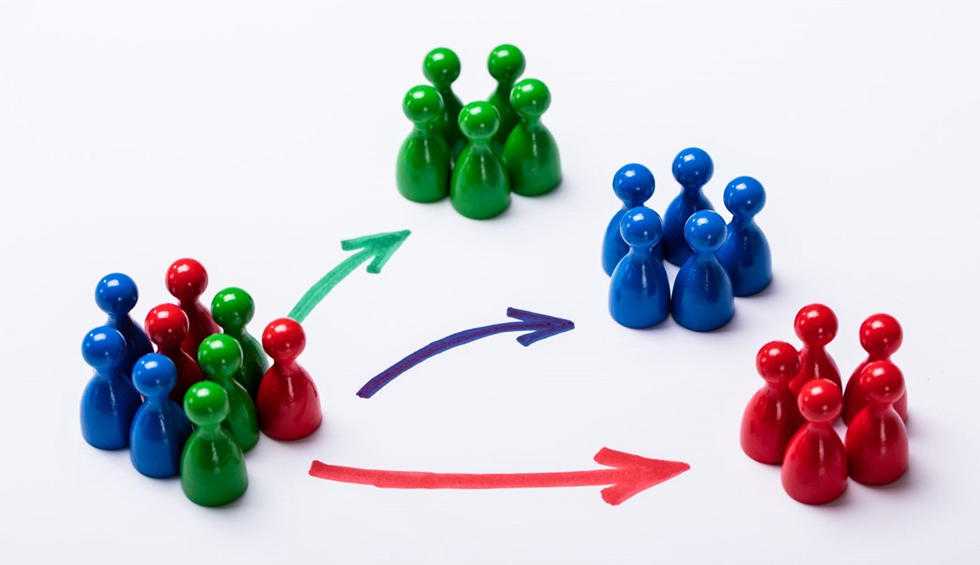

Identification of customers based on their choices and other behaviors is an important strategy in any organization. This identification may help in approaching customers with specific offers and products. An organization with a large number of customers may experience difficulty in identifying and placing into a record each customer individually. A huge amount of data processing and automated techniques are involved in extracting insights from the large information collected on customers.

There are various methods of customer segmentation. In this notebook we will focus on  the segmentation of customers using two clustering techniques – K-Means clustering and RFM. We will see the result of clustering when we implement these techniques in Python. Finally, we will discuss the comparison between these two clustering techniques.

These are the metrics that will be considered for both techniques.

Recency – How recently did the customer purchase? Highest score refers to the customer with the nearest last shopping date

Frequency – How often do they purchase?Total number of purchases. this value can be the number of Invoices or the number of products in an invoice or the number of website visits. In other words, it can be not only purchasing the product, but also using the service.

Monetary Value – How much do they spend?


**Context**
The dataset named Online Retail II was obtained from a UK-based online store and includes sales from 01/12/2009 to 09/12/2011.

This company sells souvenirs and most of their customers are also wholesalers. Within the scope of this study, only 2010-2011 sales will be consedered.

**Business Problem**
Rule-based customer segmentation method RFM and machine learning method K-Means will be compared for customer segmentation.

**Task Details**

1. Data Preprocessing
2. Customer Segmentation with RFM
3. Customer Segmentation with K-Means
4. Comparison

**Attribute Information:**

**InvoiceNo:** Invoice number. The unique number of each transaction, that is, the invoice. Aborted operation if it starts with C.

**StockCode:** Product code. Unique number for each product.

**Description:** Product name

**Quantity:** Number of products. It expresses how many of the products on the invoices have been sold.

**InvoiceDate:** Invoice date and time.

**UnitPrice:** Product price (in GBP)

**CustomerID:** Unique customer number

**Country:** Country name. Country where the customer lives.



## IMPORTING LIBRARIES AND DATA

In [1]:
!pip install yellowbrick
!pip install openpyxl
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

     |████████████████████████████████| 14.8 MB 1.8 MB/s            
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.3
    Uninstalling numpy-1.20.3:
      Successfully uninstalled numpy-1.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires pyarrow<6,>=1, but you have pyarrow 6.0.1 which is incompatible.
tfx-bsl 1.5.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,<3,>=1.15.2, but you have tensorflow 2.6.2 which is incompatible.
tensorflow 

In [2]:
df = pd.read_excel("../input/uci-online-retail-ii-data-set/online_retail_II.xlsx",sheet_name="Year 2010-2011")
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 1.DATA PREPROCESSING

In [3]:
df.shape

(541910, 8)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541910.0,9.552234,218.080957,-80995.00,1.00,3.00,10.00,80995.0
Price,541910.0,4.611138,96.759765,-11062.06,1.25,2.08,4.13,38970.0
Customer ID,406830.0,15287.684160,1713.603074,12346.00,13953.00,15152.00,16791.00,18287.0


In [5]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
Price               0
Customer ID    135080
Country             0
dtype: int64

In [6]:
df.dropna(inplace=True)
df = df[~df["Invoice"].str.contains("C", na=False)]
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]

## 2.CUSTOMER SEGMENTATION WITH RFM

In [7]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [8]:
today_date=dt.datetime(2011,12,11)
rfm=df.groupby("Customer ID").agg({"InvoiceDate": lambda x :(today_date-x.max()).days,
                               "Invoice": lambda x : x.nunique(),
                               "TotalPrice":lambda x : x.sum()})
rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [9]:
rfm.columns=["recency","frequency","monetary"]
rfm.head()

,recency,frequency,monetary
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40


In [10]:
rfm["receny_score"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])

rfm["frequency_score"] = pd.qcut(rfm["frequency"].rank(method="first"),5,labels=[1,2,3,4,5])

rfm["monetary_score"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])

rfm["rfm_score"]=rfm["receny_score"].astype("str")+rfm["frequency_score"].astype("str")
rfm.head()

,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score
Customer ID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1797.24,2,4,4,24
12349.0,19,1,1757.55,4,1,4,41
12350.0,311,1,334.40,1,1,2,11


In [11]:

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['RFM_segment'] = rfm['rfm_score'].replace(seg_map, regex=True)

rfm.reset_index()
rfm.head()

,recency,frequency,monetary,receny_score,frequency_score,monetary_score,rfm_score,RFM_segment
Customer ID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1797.24,2,4,4,24,at_Risk
12349.0,19,1,1757.55,4,1,4,41,promising
12350.0,311,1,334.40,1,1,2,11,hibernating


## 3. CUSTOMER SEGMENTATION WITH K-MEANS

In [12]:
df_rfm = rfm[['recency','frequency','monetary']]

In [13]:
sc = MinMaxScaler((0, 1))
df_rfm = sc.fit_transform(df_rfm)

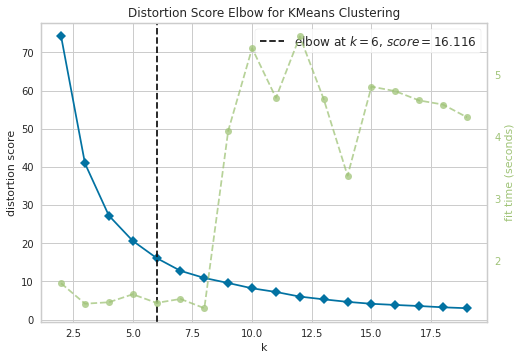

6

In [14]:
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans,k=(2, 20))
elbow.fit(df_rfm)
elbow.show()

elbow.elbow_value_

In [15]:
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(df_rfm)

kmeans.cluster_centers_

array([[0.19806158, 0.00811061, 0.00373835],
       [0.66712608, 0.00216685, 0.00211566],
       [0.0146336 , 0.33253205, 0.31405968],
       [0.04913417, 0.02314298, 0.00845238],
       [0.43225887, 0.00534809, 0.00265151],
       [0.90059093, 0.0017301 , 0.00231617]])

In [16]:
kmeans.labels_

array([5, 3, 0, ..., 3, 3, 3], dtype=int32)

In [17]:
kmeans.inertia_

16.11783782802537

In [18]:
clusters = kmeans.labels_

In [19]:
df_rfm=rfm[['recency','frequency','monetary']]
df_rfm["KMeans_Segment"] = clusters

In [20]:
df_rfm["KMeans_Segment"] = df_rfm["KMeans_Segment"] + 1

df_rfm.head()

,recency,frequency,monetary,KMeans_Segment
Customer ID,,,,
12346.0,326,1,77183.60,6
12347.0,3,7,4310.00,4
12348.0,76,4,1797.24,1
12349.0,19,1,1757.55,4
12350.0,311,1,334.40,6


## 4.COMPARISON

In [21]:
df_rfm["RFM Segment"]=rfm['RFM_segment']
df_rfm.head()

,recency,frequency,monetary,KMeans_Segment,RFM Segment
Customer ID,,,,,
12346.0,326,1,77183.60,6,hibernating
12347.0,3,7,4310.00,4,champions
12348.0,76,4,1797.24,1,at_Risk
12349.0,19,1,1757.55,4,promising
12350.0,311,1,334.40,6,hibernating


In [22]:
df_rfm[["RFM Segment","recency","frequency","monetary"]].groupby(["RFM Segment"]).agg(["mean","count"])


recency        frequency           monetary      
                           mean count       mean count         mean count
RFM Segment                                                              
about_to_sleep        53.312500   352   1.161932   352   471.994375   352
at_Risk              153.785835   593   2.876897   593  1084.535297   593
cant_loose           132.968254    63   8.380952    63  2796.155873    63
champions              6.361769   633  12.413902   633  6857.963918   633
hibernating          217.605042  1071   1.101774  1071   488.643307  1071
loyal_customers       33.608059   819   6.479853   819  2864.247791   819
need_attention        52.427807   187   2.326203   187   897.627861   187
new_customers          7.428571    42   1.000000    42   388.212857    42
potential_loyalists   17.398760   484   2.010331   484  1041.222004   484
promising             23.510638    94   1.000000    94   294.007979    94

In [23]:
df_rfm[["KMeans_Segment","recency","frequency","monetary"]].groupby(["KMeans_Segment"]).agg(["mean","count"])


recency        frequency            monetary      
                      mean count       mean count          mean count
KMeans_Segment                                                       
1                74.578384  1027   2.687439  1027   1051.728989  1027
2               249.838028   426   1.450704   426    596.561669   426
3                 6.458333    24  70.166667    24  88003.984583    24
4                19.178988  2056   5.830253  2056   2378.950993  2056
5               162.232558   516   2.112403   516    746.710349   516
6               336.920415   289   1.359862   289    652.745848   289

In [24]:
segmentation = rfm.merge(df_rfm, on="Customer ID")
segmentation.head()

,recency_x,frequency_x,monetary_x,receny_score,frequency_score,monetary_score,rfm_score,RFM_segment,recency_y,frequency_y,monetary_y,KMeans_Segment,RFM Segment
Customer ID,,,,,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,hibernating,326,1,77183.60,6,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions,3,7,4310.00,4,champions
12348.0,76,4,1797.24,2,4,4,24,at_Risk,76,4,1797.24,1,at_Risk
12349.0,19,1,1757.55,4,1,4,41,promising,19,1,1757.55,4,promising
12350.0,311,1,334.40,1,1,2,11,hibernating,311,1,334.40,6,hibernating


In [25]:
pd.DataFrame(segmentation[["RFM Segment", "KMeans_Segment"]].groupby(["KMeans_Segment", "RFM Segment"])["RFM Segment"].agg("count"))

RFM Segment
KMeans_Segment RFM Segment                     
1              about_to_sleep               245
               at_Risk                      240
               cant_loose                    36
               hibernating                  220
               loyal_customers              171
               need_attention               115
2              at_Risk                       92
               cant_loose                     5
               hibernating                  329
3              champions                     20
               loyal_customers                3
               potential_loyalists            1
4              about_to_sleep               107
               champions                    613
               loyal_customers              645
               need_attention                72
               new_customers                 42
               potential_loyalists          483
               promising                     94
5              at_Risk                      231
               cant_loose                    19
               hibernating                  266
6              at_Risk                       30
               cant_loose                     3
               hibernating                  256

While there were 10 classes in the segmentation with the RFM technique, 6 clusters emerged in the segmentation with the K-Means technique.
As a result, the results obtained with the K-Means Technique were slightly more comprehensive than those obtained with the RFM.
The customers in the potential_loyalists, loyal_customers, and champions classes overlap with cluster number 4 to a large extent. On the other hand, the customers in the hibernating class are scattered in clusters 1,2,3 and 5.